Before starting any data wrangling, import the necessary libraries and set up files as needed.

In [144]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xlrd
import re
import os
from scipy.stats import ttest_ind

In [145]:
# set up file paths for data sets
transDataFile = 'QVI_transaction_data.xlsx'
purchDataFile = 'QVI_purchase_behaviour.csv'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# check file sizes to see if a generator is needed
print(round((os.stat(transDataFile).st_size)/(1000*1024),2) > 100)
print(round((os.stat(purchDataFile).st_size)/(1000*1024),2) > 100)


False
False


Since both files are relatively small in size, we can store them in memory reather than writing generators to cycle through the data in a lazy fashion. We start by having a quick look at the data in both files to make sure it is in a usable format for us to do further analysis.

In [146]:
# start by examining the transactional data file
transData = pd.ExcelFile(transDataFile)

# checking how many worksheets are in the document
print(transData.sheet_names)

['in']


In [147]:
# checking the structure of the file
dfTransData = transData.parse('in')
print(dfTransData.head())

    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  


We can see that date is stored as an integer format due to the Excel date convention so we will convert it to an ISO format for better readability.

In [148]:
# convert date from integer format to ISO
dfTransData['DATE'] = pd.to_datetime(dfTransData['DATE'].astype(np.int64), unit = 'D', origin = "1899-12-30")
dfTransData['DATE'] = dfTransData['DATE'].apply(lambda x: datetime.date(x.year, x.month, x.day))

We now have a quick look at the Purchase Behaviour file just as we did for the Transaction Data.

In [149]:
# checking the purchase behaviour file in the same way
dfPurchData = pd.read_csv(purchDataFile)
print(dfPurchData.head())

   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream


Since both files look to be in a usable format, we can start by looking at what other data we can extract that may be useful. From the transaction data it is strraightforward to extract the weight of each product which we can add to the existing dataframe. We can then check to see that all the weights seem reasonable.

In [150]:
# extract the packet weight of each product in grams
dfTransData['WEIGHT'] = dfTransData['PROD_NAME'].str.extract('(\d+)')
print(dfTransData.head())

# check packet weights to see if there are any outliers
dfTransData['WEIGHT'].unique()

         DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  2018-10-17          1            1000       1         5   
1  2019-05-14          1            1307     348        66   
2  2019-05-20          1            1343     383        61   
3  2018-08-17          2            2373     974        69   
4  2018-08-18          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES WEIGHT  
0    Natural Chip        Compny SeaSalt175g         2        6.0    175  
1                  CCs Nacho Cheese    175g         3        6.3    175  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9    170  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0    175  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8    150  


array(['175', '170', '150', '300', '330', '210', '270', '220', '125',
       '110', '134', '380', '180', '165', '135', '250', '200', '160',
       '190', '90', '70'], dtype=object)

<Figure size 1500x500 with 0 Axes>

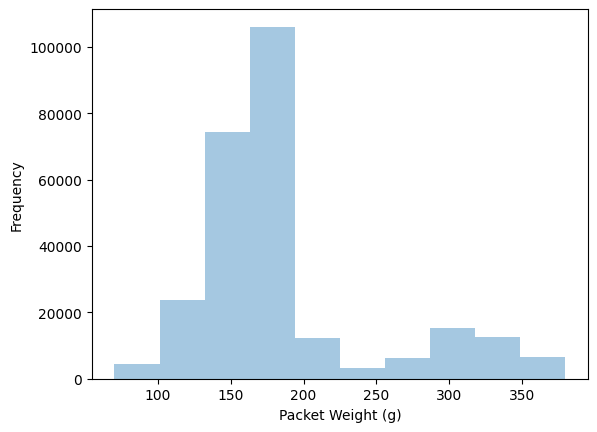

<Figure size 1500x500 with 0 Axes>

In [151]:
# packet weights vary from 70g to 380g which seems okay so visualise the weights
dfTransData.sort_values(by='WEIGHT')
sns.distplot(dfTransData['WEIGHT'], hist = True, bins = 10, kde = False)
plt.xlabel('Packet Weight (g)')
plt.ylabel('Frequency')
plt.figure(figsize = (15,5))

As we can see from the visualisation, the vast majority of crisp packets lie in the 125g to 175g region.
Now looking back to our overview of the Transaction Data, we can see that some of the product names have random characters in them which we can remove using regular expressions. Once we have the names cleaned up, we can have a look to see what kind of key-words are common in crisp packet names.

In [152]:
# clean up the PROD_NAME column by removing digits and replacing special characters with spaces
dfTransData['PROD_NAME'] = dfTransData['PROD_NAME'].str.replace(r'[0-9]+[gG]','')
dfTransData['PROD_NAME'] = dfTransData['PROD_NAME'].str.replace(r'&',' ')

# check the frequency of words within our products and display them
wordFreq = pd.Series(''.join(dfTransData['PROD_NAME']).split()).value_counts()
with pd.option_context('display.max_rows', None):
    display(wordFreq)

Chips                       49770
Kettle                      38851
Cheese                      27890
Smiths                      26969
Salt                        24719
Crinkle                     23960
Pringles                    23552
Doritos                     23431
Corn                        22063
Original                    21560
Cut                         20754
Chip                        18645
Salsa                       18094
Chicken                     15407
Chilli                      15390
Sea                         14145
Sour                        13882
Thins                       13183
Crisps                      12607
Vinegar                     12402
RRD                         11090
Sweet                       11060
Supreme                     10963
Chives                      10951
Cream                       10723
Infuzions                   10371
Popd                         9693
WW                           9592
Tortilla                     9580
BBQ           

Having a quick look through the word frequencies we can see there are 18094 ocurences of the word Salsa which is unlikely to be related to crisps. Since we are not interested in salsa data we can remove such occurences from our data. There may be other such words but the vast majority of words are low in frequency so it suffices to consider the m=oens that will have the most impact on our data.

In [153]:
# Skimming through we can see there are 18094 occurences of salsa
# Remove all occurences and check they have been removed
print(dfTransData.shape)
dfTransData = dfTransData[dfTransData['PROD_NAME'].str.contains(r"[Ss]alsa") == False]
print(dfTransData.shape)

(264836, 9)
(246742, 9)


In [154]:
# check for missing value types (Nan) and summarise the data
print(dfTransData.isnull().values.any())
dfTransData.describe()

False


,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


Now that we have checked that all the salsa data has been removed and have checked that there are no missing value datapoint in our dataframe, we can start having a deeper look at our data. In the product quantity column we see that there is at least once occurence of a purchase containing 200 items - this seems highly unusual for a normal customer.

In [155]:
# purchases with PROD_QTY = 200 seem unusual
print(dfTransData.loc[dfTransData['PROD_QTY'] == 200])

             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762  2018-08-19        226          226000  226201         4   
69763  2019-05-20        226          226000  226210         4   

                          PROD_NAME  PROD_QTY  TOT_SALES WEIGHT  
69762  Dorito Corn Chp     Supreme        200      650.0    380  
69763  Dorito Corn Chp     Supreme        200      650.0    380  


Upon further investigation we can see that both such purchases have been made by the same customer with a notable interval between both transaction dates. It is safe to conclude that these transaction are most likely not for personal use so we can discard them from our dataset.

In [156]:
# both large purchases have been made by the same customer most likely not for personal use so remove them
dfTransData = dfTransData[dfTransData['LYLTY_CARD_NBR'] != 226000]

# look at the data again
dfTransData.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


After looking at the data again the maximum product quantity has gone down to 5 which seems much more reasonable and doesn't warrant more investigation. Now we can look at other things such as the dates on which purchases were made.

In [157]:
# checking the number of dates in the data
print(len(dfTransData['DATE'].unique()))

364


In [158]:
# we are missing one date from the year - generate a sorted list of the dates
dates = sorted(dfTransData['DATE'])
print(dates[0], dates[-1])

2018-07-01 2019-06-30


In [159]:
# compare with a full list of all dates within the same range
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(dates)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

We can see that exactly one data was missing from our data which corresponded to Christmas Day. Stores are shut on Christmas day so there will obviously be no sales data for the day. The logical next step is to then have a look at how sales vared over the course of the year.

<Figure size 1500x500 with 0 Axes>

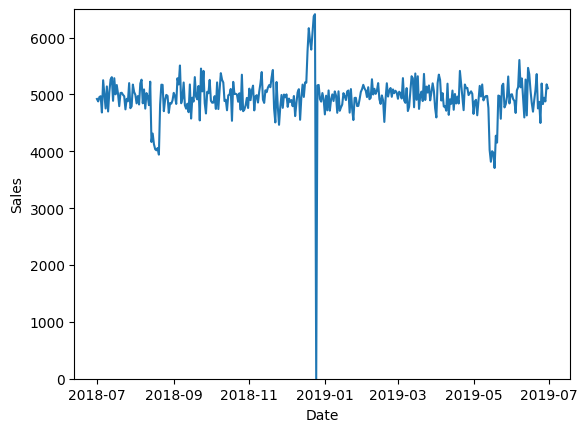

<Figure size 1500x500 with 0 Axes>

In [160]:
#create containers for affregates sales and relevant dates
dates = pd.date_range(start = '2018-07-01', end = '2019-06-30')
justSales = pd.pivot_table(dfTransData, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
justSales = justSales['TOT_SALES'].to_list()

#insert the missing data for christmas and convert to a dataframe
justSales.insert(177,0)
dfSalesData = pd.DataFrame({'TOT_SALES':justSales}, index = dates)

#plotting the data
sns.lineplot(data = dfSalesData, legend = False)
plt.ylim(0,6500)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.figure(figsize = (15,5))

It is clear to see the sales over all the stores average around 5000 packets of crisps per day over the course of the year. We do see an increase in the run up towards Christmas as well as decreases around the start of June and the end of August. The increase during the Christmas period is expected but there are no obvious explanations for the others - they don't seem to be drastically different to the average so they shouldn't warrant any further investigation.

In [161]:
# see what other data we can extract from the dataset
print(dfTransData.head())

         DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  2018-10-17          1            1000       1         5   
1  2019-05-14          1            1307     348        66   
2  2019-05-20          1            1343     383        61   
3  2018-08-17          2            2373     974        69   
4  2018-08-18          2            2426    1038       108   

                              PROD_NAME  PROD_QTY  TOT_SALES WEIGHT  
0    Natural Chip        Compny SeaSalt         2        6.0    175  
1                  CCs Nacho Cheese             3        6.3    175  
2    Smiths Crinkle Cut  Chips Chicken          2        2.9    170  
3    Smiths Chip Thinly  S/Cream Onion          5       15.0    175  
4  Kettle Tortilla ChpsHny Jlpno Chili          3       13.8    150  


After looking at the data again, another data point we can extract is the brand of each product. Without loss of generality it is safe to assume that the first word in PROD_NAME corresponds to our brand.

In [162]:
# extract brand names by assuming WLOG that first word of PROD_NAME is the brand
dfTransData['BRAND'] = dfTransData['PROD_NAME'].str.split().str.get(0)
print(dfTransData['BRAND'].unique())

['Natural' 'CCs' 'Smiths' 'Kettle' 'Grain' 'Doritos' 'Twisties' 'WW'
 'Thins' 'Burger' 'NCC' 'Cheezels' 'Infzns' 'Red' 'Pringles' 'Dorito'
 'Infuzions' 'Smith' 'GrnWves' 'Tyrrells' 'Cobs' 'French' 'RRD' 'Tostitos'
 'Cheetos' 'Woolworths' 'Snbts' 'Sunbites']


In the list of brands we can see a number of contractions and abbreviations for common brands. It is fairly easy to clean this up.

In [163]:
# there are a lot of contractions that we can replace
def switch(name):
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name

#check that all the contractions have been replaced    
dfTransData['BRAND'] = dfTransData['BRAND'].apply(lambda x: switch(x))
print(dfTransData['BRAND'].unique())

['Natural Chip Co' 'CCs' 'Smiths' 'Kettle' 'Grain Waves' 'Doritos'
 'Twisties' 'Woolworths' 'Thins' 'Burger' 'Cheezels' 'Infuzions'
 'Red Rock Deli' 'Pringles' 'Tyrrells' 'Cobs' 'French' 'Tostitos'
 'Cheetos' 'Sunbites']


There aren't any more obvious data point to extract from the transacton data so we can now have a deeper look at the purchase behaviour data.

In [164]:
print(dfPurchData.head())

   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream


In [165]:
print(dfPurchData['LIFESTAGE'].unique())
print(dfPurchData['PREMIUM_CUSTOMER'].unique())
print(dfPurchData.describe())

['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']
['Premium' 'Mainstream' 'Budget']
       LYLTY_CARD_NBR
count    7.263700e+04
mean     1.361859e+05
std      8.989293e+04
min      1.000000e+03
25%      6.620200e+04
50%      1.340400e+05
75%      2.033750e+05
max      2.373711e+06


In [166]:
print(dfPurchData.isnull().values.any())

False


After a quick look all the data seems to be correctly formatted for our use case and ther aren't any missing data types. Now we can start with some simple visualisations such as looking at our distributions of customer types and their respective membership types.

<Figure size 1500x500 with 0 Axes>

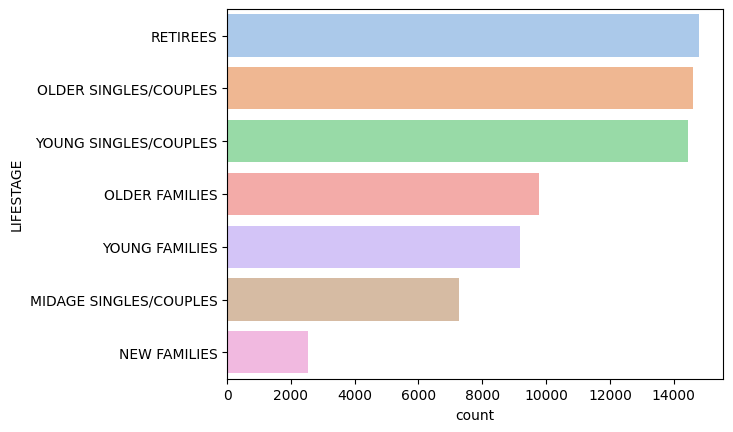

<Figure size 1500x500 with 0 Axes>

In [167]:
# visualising lifestage of customers
sns.countplot(y = dfPurchData['LIFESTAGE'], order = dfPurchData['LIFESTAGE'].value_counts().index, palette = sns.color_palette('pastel'))
plt.figure(figsize = (15,5))

It is clear to see that the overwhelming majority of customers are in small groups rather than being in families. It will be interesting to see later if they also contribute to more sales compared to families. We can do the same for customer membership types.

<Figure size 1500x500 with 0 Axes>

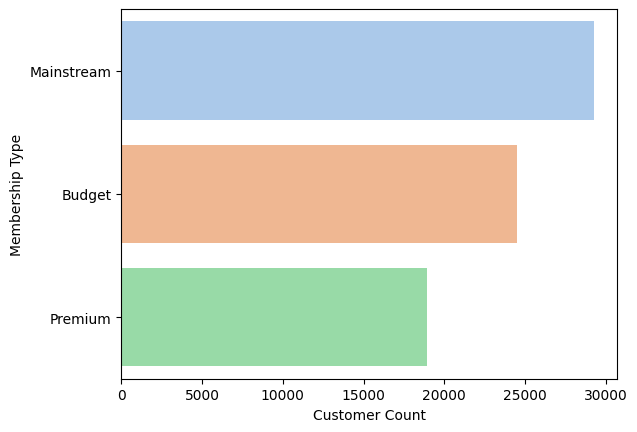

<Figure size 1500x500 with 0 Axes>

In [168]:
# same visualisation for customer membership type
sns.countplot(y = dfPurchData['PREMIUM_CUSTOMER'], order = dfPurchData['PREMIUM_CUSTOMER'].value_counts().index, palette = sns.color_palette('pastel'))
plt.xlabel('Customer Count')
plt.ylabel('Membership Type')
plt.figure(figsize = (15,5))

The majority of customers have a mainstream membership and as expected the premium members are the least numerous.

Since all the data in both tables has been correctly formated and there are no glaring discrepencies with any of our basic visualisations, it makes sense to merge all our data before we do any deeper analysis.

In [169]:
# merging all the data into one dataframe
dfSales = dfTransData.set_index('LYLTY_CARD_NBR').join(dfPurchData.set_index('LYLTY_CARD_NBR'))
dfSales = dfSales.reset_index()
dfSales = dfSales.sort_values(by='DATE').reset_index(drop=True)
print(dfSales.head())

# checking that there are no null values
print(dfSales.isnull().values.any())

   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0           21037  2018-07-01         21   17576        62   
1           25040  2018-07-01         25   21704        87   
2           59236  2018-07-01         59   55555        42   
3          271083  2018-07-01        271  268688        97   
4           65015  2018-07-01         65   61737        17   

                             PROD_NAME  PROD_QTY  TOT_SALES WEIGHT  \
0         Pringles Mystery    Flavour          2        7.4    134   
1  Infuzions BBQ Rib   Prawn Crackers          2        7.6    110   
2  Doritos Corn Chip Mexican Jalapeno          2        7.8    150   
3                 RRD Salt   Vinegar           2        6.0    165   
4       Kettle Sensations   BBQ Maple          2        9.2    150   

           BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0       Pringles               RETIREES       Mainstream  
1      Infuzions         OLDER FAMILIES           Budget  
2        Doritos  OLDER SINGL

Now that we have all the data merged into a singular dataframe we can do some deeper analysis. Some of the interesting metrics we may want to look at going forward are:

1. What kind of customers purchase the most crisps? - We should take into account the membershiptype of customers as well as their lifestage
2. How many packets of crisps do customers buy on average? - Again it makes sense to split customers into their respective membership types and lifestage groups
3. How much does a packet of crisps cost on average?
4. How much does a packet of crisps weigh on average?

We will explore those metrics in order. To start we will split up our data by customer types and look at their respective sales totals.

In [170]:
# sales by lifestage and membership type
salesLifeMem = pd.DataFrame(dfSales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesLifeMem.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
salesLifeMem.sort_values(by = 'Total Sales', ascending = False, inplace = True)
print(salesLifeMem)

                                         Total Sales
LIFESTAGE              PREMIUM_CUSTOMER             
OLDER FAMILIES         Budget              156863.75
YOUNG SINGLES/COUPLES  Mainstream          147582.20
RETIREES               Mainstream          145168.95
YOUNG FAMILIES         Budget              129717.95
OLDER SINGLES/COUPLES  Budget              127833.60
                       Mainstream          124648.50
                       Premium             123537.55
RETIREES               Budget              105916.30
OLDER FAMILIES         Mainstream           96413.55
RETIREES               Premium              91296.65
YOUNG FAMILIES         Mainstream           86338.25
MIDAGE SINGLES/COUPLES Mainstream           84734.25
YOUNG FAMILIES         Premium              78571.70
OLDER FAMILIES         Premium              75242.60
YOUNG SINGLES/COUPLES  Budget               57122.10
MIDAGE SINGLES/COUPLES Premium              54443.85
YOUNG SINGLES/COUPLES  Premium              39

<Figure size 1000x1500 with 0 Axes>

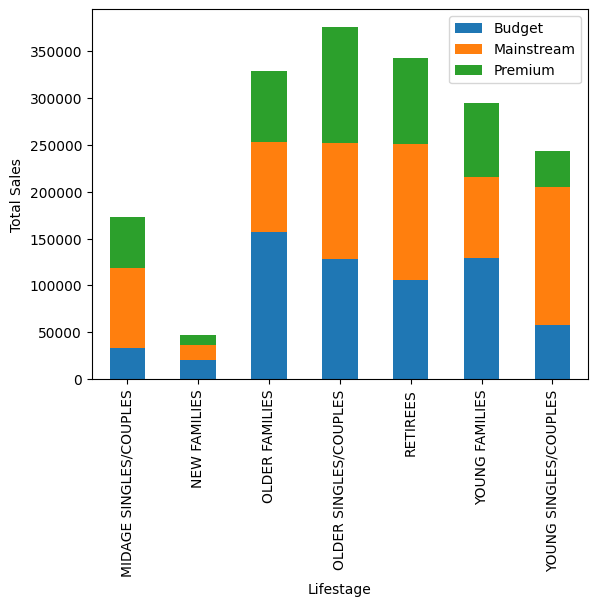

<Figure size 1000x1500 with 0 Axes>

In [171]:
# visualise the sales data by membership type and lifestage
salesLifeMem.unstack().plot(kind = 'bar', stacked = True, orientation = 'vertical')
plt.xlabel('Lifestage')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'])
plt.figure(figsize = (10,15))

We can clearly see that the type of customers which produce lots of sales (Retirees, Older Singles) also are the most numerous as we say before. We can also start to see the impact of estabilished (not new) families - even if they are not the most numerous they contribute a lot to the overall sales.

We can apply these same ideas to the type of customers that are visiting the stores.

In [172]:
# in the same way look at number of customers by membership type and lifestage
custLifeMem = pd.DataFrame(dfSales.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
custLifeMem.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
custLifeMem.sort_values(by = 'Number of Customers', ascending = False)
print(custLifeMem)

                                         Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                  
Budget           MIDAGE SINGLES/COUPLES                 1474
                 NEW FAMILIES                           1087
                 OLDER FAMILIES                         4611
                 OLDER SINGLES/COUPLES                  4849
                 RETIREES                               4385
                 YOUNG FAMILIES                         3953
                 YOUNG SINGLES/COUPLES                  3647
Mainstream       MIDAGE SINGLES/COUPLES                 3298
                 NEW FAMILIES                            830
                 OLDER FAMILIES                         2788
                 OLDER SINGLES/COUPLES                  4858
                 RETIREES                               6358
                 YOUNG FAMILIES                         2685
                 YOUNG SINGLES/COUPLES                  7917
Premium          MIDAGE 

<Figure size 1000x1500 with 0 Axes>

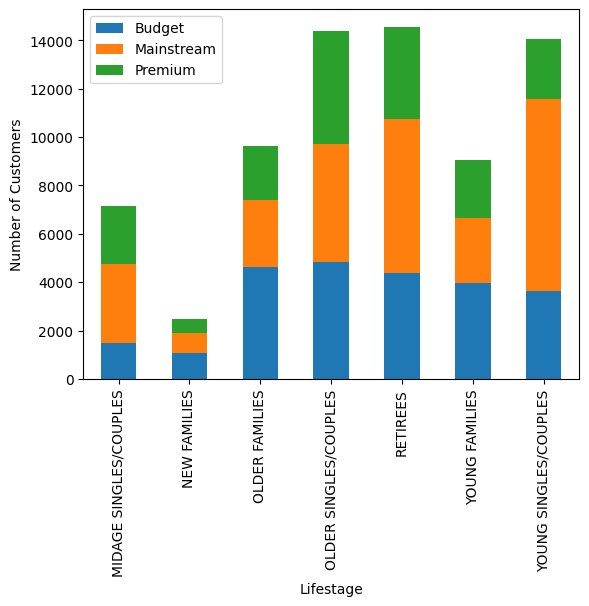

<Figure size 1000x1500 with 0 Axes>

In [173]:
# new data frame with swappe columns 
custLifeMem2 = pd.DataFrame(dfSales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())

# visualise the customer data by membership and lifestage
custLifeMem2.unstack().plot(kind = 'bar', stacked = True, orientation = 'vertical')
plt.xlabel('Lifestage')
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'])
plt.figure(figsize = (10,15))

We already had an idea of the distribution of customers in the stored but now we can have a deeper look at what kind of customer membership they have. Most of our premium cutomers come form the older singles/couples or retirees category.

We can now look at how many packets of crisps our customers pruchase on average while keeping in kind their lifestages and membershipt types.

In [174]:
# consider average purchase qty per customer by lifestage and member type
qtyLifeMem = pd.DataFrame(dfSales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum()/dfSales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
print(qtyLifeMem)

                                                0
LIFESTAGE              PREMIUM_CUSTOMER          
MIDAGE SINGLES/COUPLES Budget            6.026459
                       Mainstream        6.432080
                       Premium           6.078514
NEW FAMILIES           Budget            4.821527
                       Mainstream        4.891566
                       Premium           4.815652
OLDER FAMILIES         Budget            9.076773
                       Mainstream        9.255380
                       Premium           9.071717
OLDER SINGLES/COUPLES  Budget            6.781398
                       Mainstream        6.712021
                       Premium           6.769543
RETIREES               Budget            6.141847
                       Mainstream        5.925920
                       Premium           6.103358
YOUNG FAMILIES         Budget            8.722995
                       Mainstream        8.638361
                       Premium           8.716013


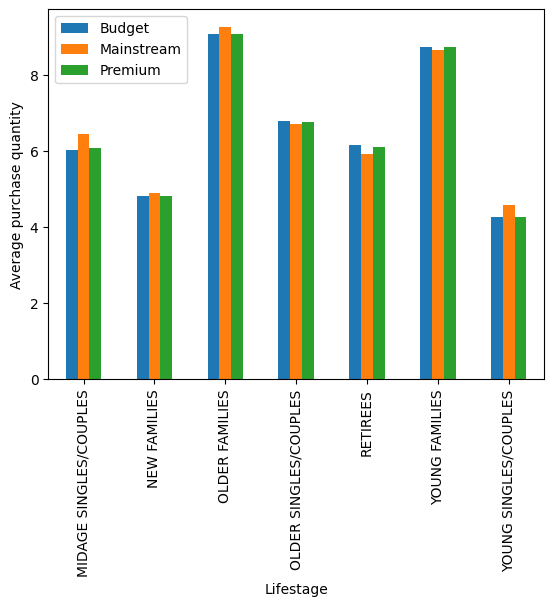

<Figure size 1000x1500 with 0 Axes>

In [175]:
# visualise average qty data by lifestage and member type
qtyLifeMem.unstack().plot(kind='bar')
plt.xlabel('Lifestage')
plt.ylabel('Average purchase quantity')
plt.legend(['Budget', 'Mainstream', 'Premium'])
plt.figure(figsize=(10,15))
plt.savefig('fig1.png')
plt.show()

As expected, families tend to buy more packets of crisps than singles or couples. We can do the same analysis for the average price of each transaction.

<Figure size 1000x1500 with 0 Axes>

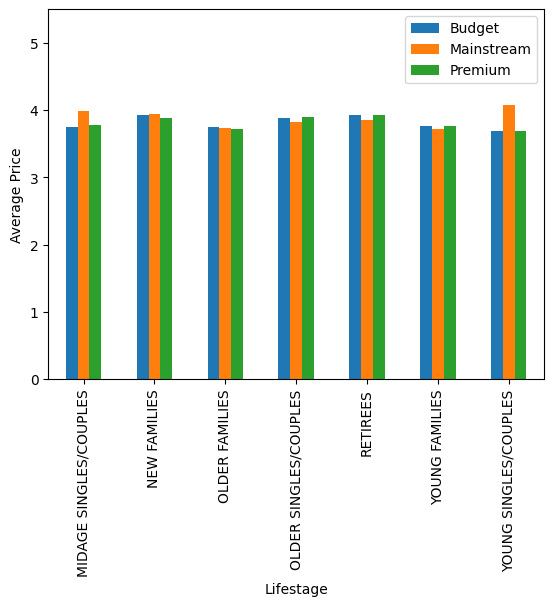

<Figure size 1000x1500 with 0 Axes>

In [176]:
# calculate the price of each type of crisp
dfSales['PRICE'] = dfSales['TOT_SALES']/dfSales['PROD_QTY']

# consider average transaction cost by lifestage and membership type
costLifeMem = pd.DataFrame(dfSales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum()/dfSales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
costLifeMem.unstack().plot(kind = 'bar')
plt.ylim(0,5.5)
plt.xlabel('Lifestage')
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'])
plt.figure(figsize=(10,15))

On average we can see that most people tend to spend the same amount on crisps regardless of their age or their family status. There doesn't seem to be strong evidence that any such goup may spend a statistically significant amount more than any other group. We can check the statistically dignificany of these differences by performing a t-test to confirm our hypothesis.

In [177]:
# split data into groups
mainstream = dfSales['PREMIUM_CUSTOMER'] == 'Mainstream'
youngMid = (dfSales['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') | (dfSales['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')
premBud = dfSales['PREMIUM_CUSTOMER'] != 'Mainstream'
grp1 = dfSales[mainstream & youngMid]['PRICE']
grp2 = dfSales[premBud & youngMid]['PRICE']

# compute the t test
stat, pval = ttest_ind(grp1.values, grp2.values, equal_var = False)
print(pval, stat)

6.967354232991983e-306 37.6243885962296


The test resulted in a p-value that is close to zero meaning that there is in fact a statistically significant differnce in prices - namely that young and mid-aged singles are couples are much more likely to spend more money on crisps.

Going forward we can analsyse trends with specific subgroups of our data. For our mainstream young signles/couples, let's have a look at what kind of brands are the most popular.

We have found quite a few interesting insights that we can dive deeper into. We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

Text(0, 0.5, 'Brand')

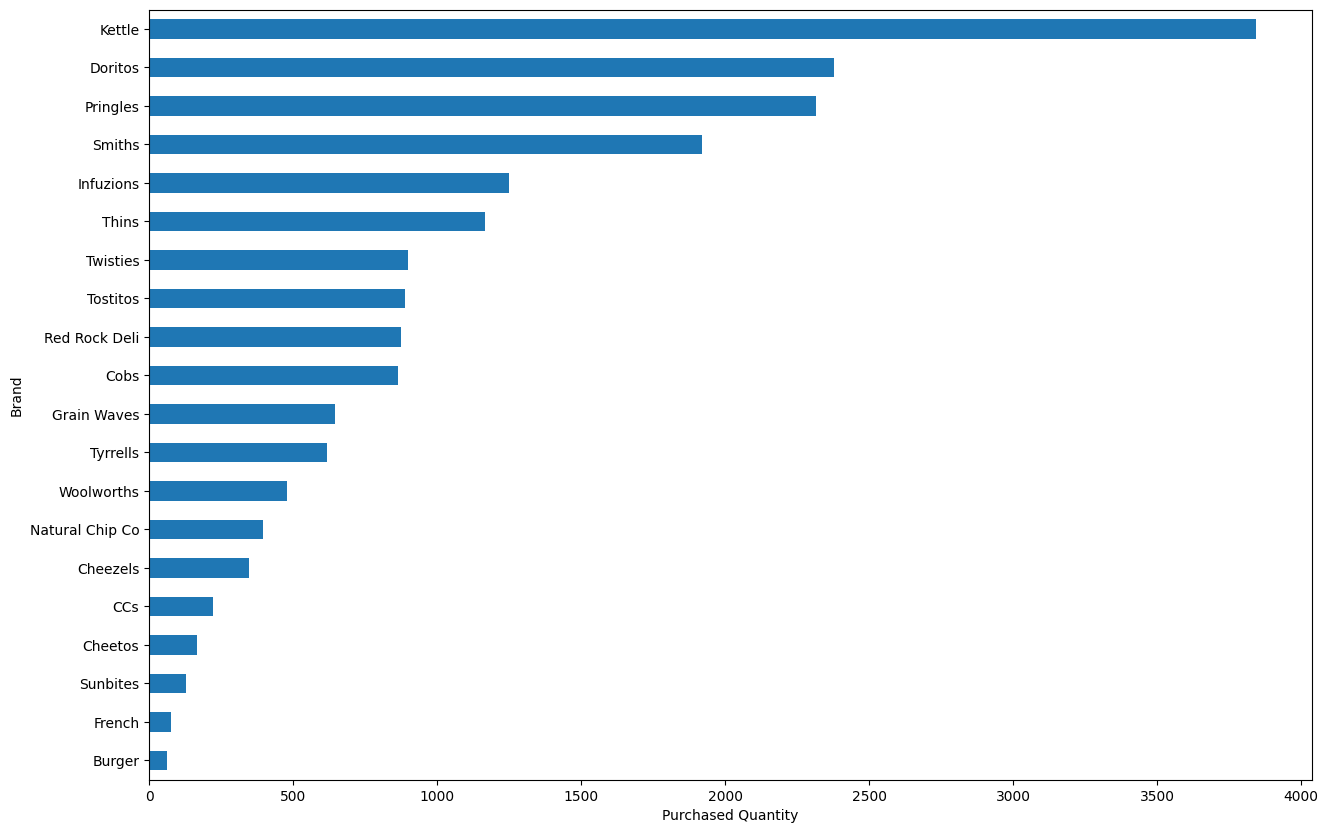

In [178]:
# data for crisp purchases of young people that are mainstream customers
youngMain = dfSales.loc[dfSales['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES']
youngMain = youngMain.loc[youngMain['PREMIUM_CUSTOMER'] == 'Mainstream']

# visualise the data
brandData = youngMain['BRAND'].value_counts().sort_values(ascending = True).plot.barh(figsize =(15,10))
brandData.set_xlabel('Purchased Quantity')
brandData.set_ylabel('Brand')

We can see that the Kettle brand id dominating this category of customer. In the same way let's have a look at what size of packets our mainstream young signles/couples tend to buy.

Text(0, 0.5, '(Brand, Packet Weight g)')

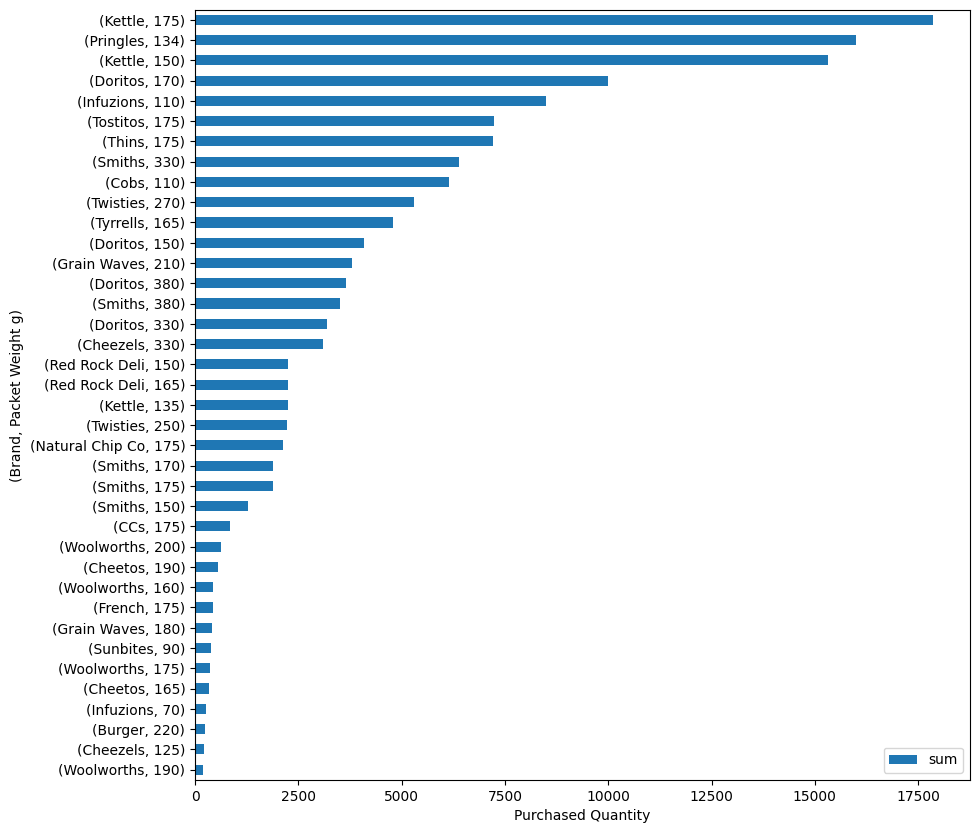

In [179]:
# data for packet sizes for young mainstream purchases
packSize = youngMain.groupby(['BRAND', 'WEIGHT'], as_index = False)['TOT_SALES'].agg(['sum'])
sizeData = packSize.sort_values(by = 'sum').plot.barh(y = "sum", figsize=(10,10))
sizeData.set_xlabel('Purchased Quantity')
sizeData.set_ylabel('(Brand, Packet Weight g)')

After all our analysis of the data there are a number of things we can takeaway.

1. Young Singles and Couples that have the mainstream membership are the most numerous within our customers which in turn explains their high sales relative to each other category.

2. Despite established families (ones that are not new) not being the most common, they expectedly have the highest number of sales on average both in terms of quantity of crisps bought and average expendature.

3. After our t-test, it is clear to see that young and mid-aged singles and couples that have the mainstream membership have the highest amount of spending on average. The differnce between them and the non-mainstream categroy is statistically significant.
